### “GrabCut” — Interactive Foreground Extraction using Iterated Graph Cuts

### Yudhik Agrawal
#### 20161093

In [6]:
import sys
import numpy as np
import cv2
import igraph as ig
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from random import randint

### GrabCut 
- GrabCut is an image segmentation method based on **graph cuts**. 
- Requires a **user-specified bounding box** around the object to be segmented.  
- Estimates the color distribution of the target object and that of the  background using a **Gaussian Mixture Model**.
- Uses the GMM to construct a **Markov Random Field** over the pixel labels, with an energy function that prefers connected regions having the same label, and running a graph cut based optimization to infer their values. 
- This two-step procedure is repeated until **convergence**. 

In [2]:
BG = 0 # Background
FG = 1 # Foreground
EXP_FG = 3 # Expected foreground
EXP_BG = 2 # Expected background


**beta_smoothing** : 
* First find the left_difference, upleft_difference, right_difference, upright_difference arrays.
* Finds beta according to the formula mentioned in the paper.
* Find the smoothing parameter arrays based on the formulae in the the paper corresponding to the 4-neighbourhodd positions.

In [3]:
def beta_smoothing(img, gamma):
    
    rows, cols = img[:, :, 2].shape
    
    left = img[:, 1:] - img[:, :-1]
    up = img[1:, :] - img[:-1, :]
    
    upleft = img[1:, 1:] - img[:-1, :-1]
    upright = img[1:, :-1] - img[:-1, 1:]

    
    sleft = np.sum(left*left)
    sup = np.sum(up*up)
    supleft = np.sum(upleft*upleft)
    supright = np.sum(upright*upright)
    
    ssum = sleft + sup + supleft + supright
    
    beta = 1 / (2 * ssum / (4*cols*rows - 3*cols - 3*rows + 2))
    
    left_V    = gamma * np.exp(-beta * np.sum(left*left, axis=2))
    up_V      = gamma * np.exp(-beta * np.sum(up*up, axis=2))
    upleft_V  = gamma / np.sqrt(2) * np.exp(-beta * np.sum(upleft*upleft, axis=2))
    upright_V = gamma / np.sqrt(2) * np.exp(-beta * np.sum(upright*upright, axis=2))
    
    return left_V, upleft_V, up_V, upright_V

**construct_graph** : 
* Constructs the graph for performing mincut by building edges and graph edge capacities.
* The graph has 2 type of edges
    - **Unary Potentials:** These represent the likelihood of a pixel belonging to either the foreground or background.
    - **Pairwise Potentials:** These enforce the smoothness constraints. These edges are put between all pairs of adjacent pixels.
* Finally, uses the igraph moule to build a graph object

In [4]:
def construct_graph(img, left_V, upleft_V, up_V, upright_V, bgd_gmm, fgd_gmm, mask, gc_source, gc_sink, gamma):
    
    rows, cols = img[:, :, 2].shape
    edges, capacity = [], []

    # t-links
    
    ## pr_indices
    pr_indexes = np.where(np.logical_or(
        mask.reshape(-1) == EXP_BG, mask.reshape(-1) == EXP_FG))
    
    edges.extend(
        list(zip([gc_source] * pr_indexes[0].size, pr_indexes[0])))
    D = bgd_gmm.score_samples(img.reshape(-1, 3)[pr_indexes])
    D = -D
    capacity.extend(D.tolist())

    edges.extend(
        list(zip([gc_sink] * pr_indexes[0].size, pr_indexes[0])))
    D = fgd_gmm.score_samples(img.reshape(-1, 3)[pr_indexes])
    D = -D
    capacity.extend(D.tolist())

    ## bgd_indices
    bgd_indexes = np.where(mask.reshape(-1) == BG)
    fgd_indexes = np.where(mask.reshape(-1) == FG)
    
    edges.extend(list(zip([gc_source] * bgd_indexes[0].size, bgd_indexes[0])))
    edges.extend(list(zip([gc_sink] * bgd_indexes[0].size, bgd_indexes[0])))
    
    capacity.extend([0] * bgd_indexes[0].size)
    capacity.extend([9 * gamma] * bgd_indexes[0].size)
    
    edges.extend(list(zip([gc_source] * fgd_indexes[0].size, fgd_indexes[0])))
    edges.extend(list(zip([gc_sink] * fgd_indexes[0].size, fgd_indexes[0])))
    
    capacity.extend([9 * gamma] * fgd_indexes[0].size)
    capacity.extend([0] * fgd_indexes[0].size)

    # n-links
    img_indexes = np.arange(rows * cols, dtype=np.uint32).reshape(rows, cols)
    
    #left_neighbourhood
    mask1_1 = img_indexes[:, 1:].reshape(-1)
    mask2_1 = img_indexes[:, :-1].reshape(-1)
    
    #up_neighbourhood
    mask1_2 = img_indexes[1:, :].reshape(-1)
    mask2_2 = img_indexes[:-1, :].reshape(-1)
    
    #upleft_neighbourhood
    mask1_3 = img_indexes[1:, 1:].reshape(-1)
    mask2_3 = img_indexes[:-1, :-1].reshape(-1)
    
    #upright_neighbourhood
    mask1_4 = img_indexes[1:, :-1].reshape(-1)
    mask2_4 = img_indexes[:-1, 1:].reshape(-1)
    
    edges.extend(list(zip(mask1_1, mask2_1)))
    edges.extend(list(zip(mask1_2, mask2_2)))
    edges.extend(list(zip(mask1_3, mask2_3)))
    edges.extend(list(zip(mask1_4, mask2_4)))
    
    capacity.extend(left_V.reshape(-1).tolist())
    capacity.extend(up_V.reshape(-1).tolist())
    capacity.extend(upleft_V.reshape(-1).tolist())
    capacity.extend(upright_V.reshape(-1).tolist())

    gc_graph = ig.Graph(2 + cols * rows)
    gc_graph.add_edges(edges)
    
    return gc_graph, capacity

### Estimation Method

* Runs **st mincut** on the constructed graph to **minimise the energy**.
* Using the above GMM, a new pixel distribution is generated. That is, labels are assigned either to the foreground or the background based on the GMM and its neighbouring constraints. 

In [5]:
def estimate_segmentation(img, gc_graph, gc_source, gc_sink, capacity, mask):
    
    rows, cols = img[: ,: ,2].shape
    
    img_indexes = np.arange(rows * cols, dtype=np.uint32).reshape(rows, cols)
    pr_indexes = np.where(np.logical_or(mask == EXP_BG, mask == EXP_FG))
    mincut = gc_graph.st_mincut(gc_source, gc_sink, capacity)
    
    mask[pr_indexes] = np.where(
        np.isin(img_indexes[pr_indexes], mincut.partition[0]),EXP_FG, EXP_BG)
    
    return mask

**run** : Fits and re-prodicts the gmm parameters and calls other major functions for the implementation of grabcut.

In [6]:
def classify_pixels(mask):
    """
    This function classifies the pixels into indices based on the current values in the mask.
    """
    bgd_indexes = np.where(np.logical_or(
        mask == BG, mask == EXP_BG))
    fgd_indexes = np.where(np.logical_or(
        mask == FG, mask == EXP_FG))
    
    return fgd_indexes, bgd_indexes

In [7]:
def calc(img, fgd_indexes, bgd_indexes, left_V, upleft_V, up_V, upright_V, bgd_gmm, fgd_gmm, comp_idxs, mask, gc_source, gc_sink, gamma, num_iters=5):
    for num in range(num_iters):       
        ## FG/BG gmm fit
        bgd_gmm.fit(img[bgd_indexes])
        fgd_gmm.fit(img[fgd_indexes])
        
        ## FG/BG gmm_predict
        comp_idxs[bgd_indexes] = bgd_gmm.predict(img[bgd_indexes])
        comp_idxs[fgd_indexes] = fgd_gmm.predict(img[fgd_indexes])

        bgd_gmm.fit(img[bgd_indexes], comp_idxs[bgd_indexes])
        fgd_gmm.fit(img[fgd_indexes], comp_idxs[fgd_indexes])
        
        gc_graph, capacity = construct_graph(img, left_V, upleft_V, up_V, upright_V, bgd_gmm, \
                                                fgd_gmm, mask, gc_source, gc_sink, gamma)
        
        mask = estimate_segmentation(img, gc_graph, gc_source, gc_sink, \
                                                               capacity, mask)
        fgd_indexes, bgd_indexes = classify_pixels(mask)
    return mask

In [8]:
def grabcut(img, mask, bbox, gmm_comps=5, num_iters=3):

    rows, cols = img[:, :, 2].shape
    gc_source = cols * rows
    img = img.astype(np.float64)
    comp_idxs = np.zeros((rows, cols), dtype=np.uint32)
    gc_sink = gc_source + 1
    gamma, beta = 50, 0  # gamma as suggested in paper 
    
    left_V, upleft_V, up_V, uEXPight_V = beta_smoothing(img, gamma)
    
    mask[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]] = EXP_FG
    
    fgd_indexes, bgd_indexes = classify_pixels(mask)
    
    left_V = np.zeros((rows, cols - 1))
    up_V = np.zeros((rows - 1, cols))
    upleft_V = np.zeros((rows - 1, cols - 1)) 
    upright_V = np.zeros((rows - 1, cols - 1))    
    
    
    bgd_gmm = GaussianMixture(n_components = gmm_comps)
    fgd_gmm = GaussianMixture(n_components = gmm_comps)

    mask = calc(img, fgd_indexes, bgd_indexes, left_V, upleft_V, up_V, uEXPight_V, bgd_gmm, fgd_gmm, comp_idxs, mask, gc_source, gc_sink, gamma, num_iters)

    mask2 = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
    return mask2

### Experiments on provided Images
* Multiple combinations of **num_iters** and **num_gmm_components** tried.

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


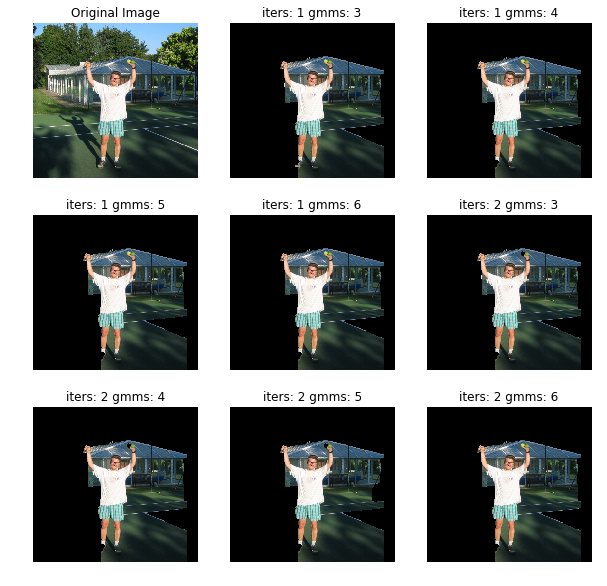

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


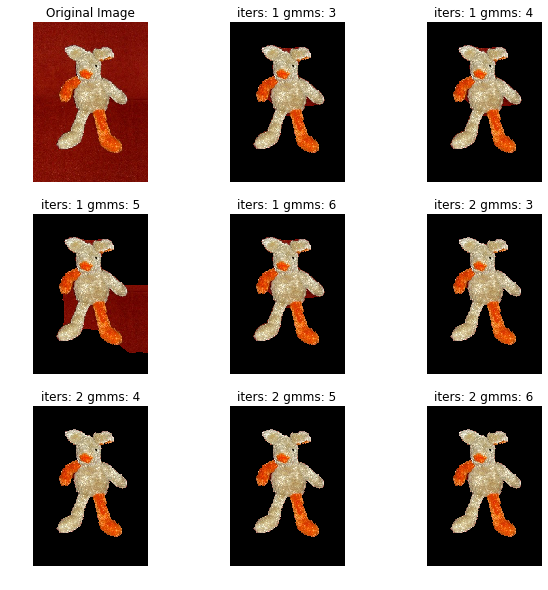

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


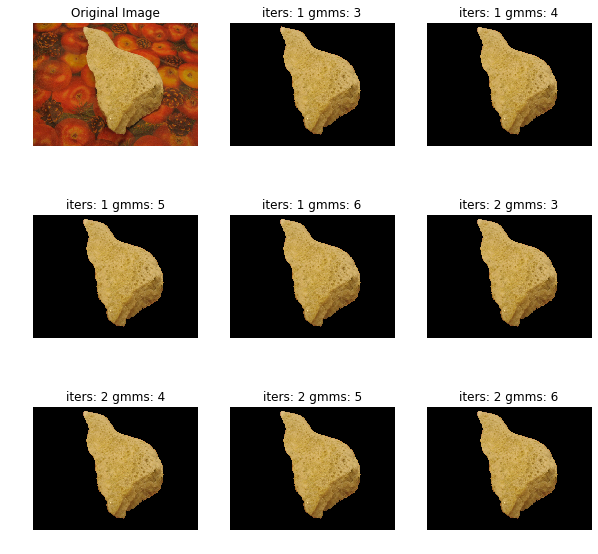

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


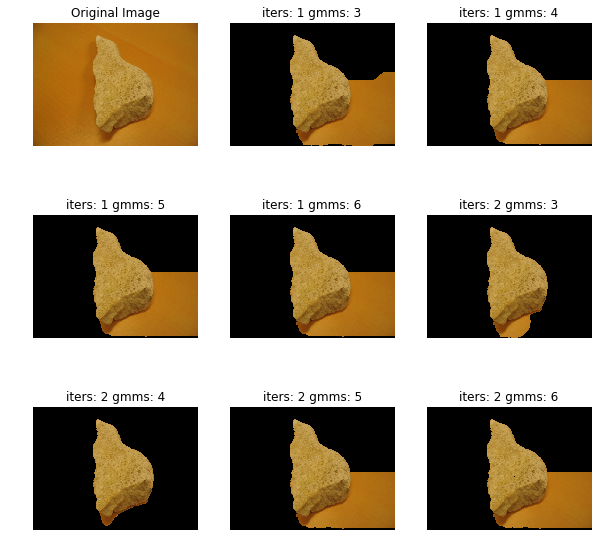

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


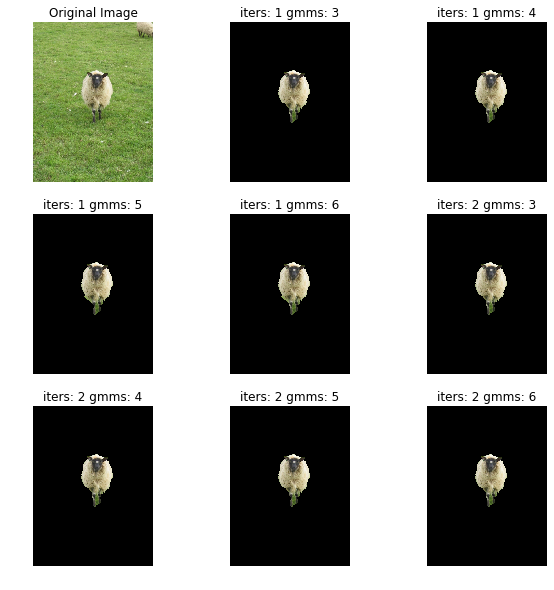

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


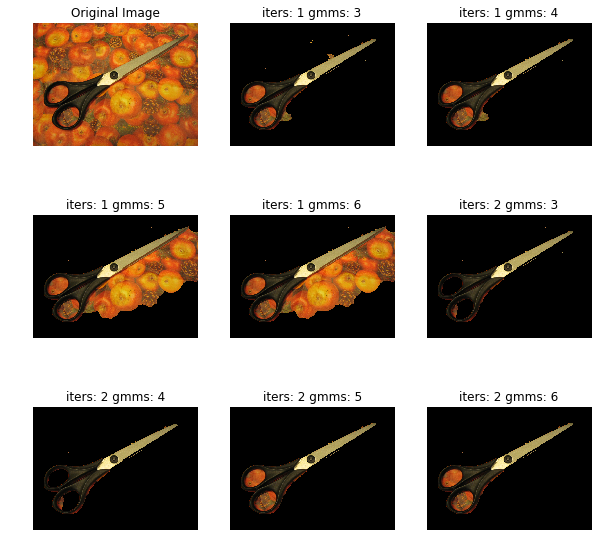

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


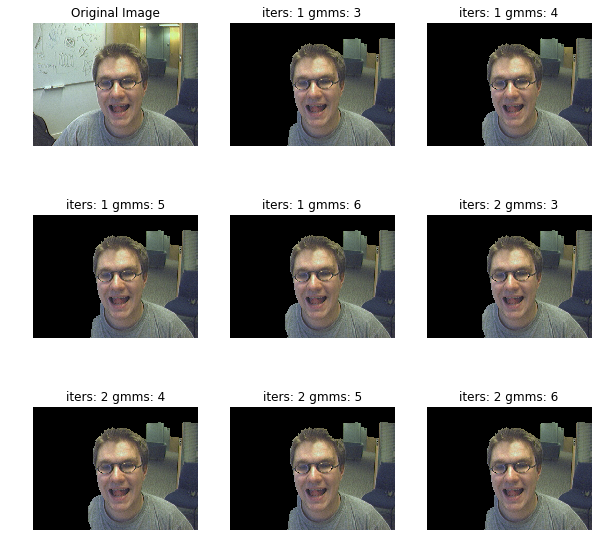

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


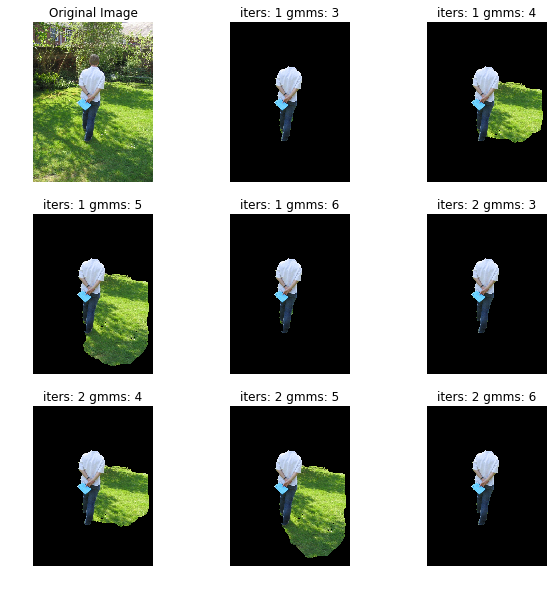

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


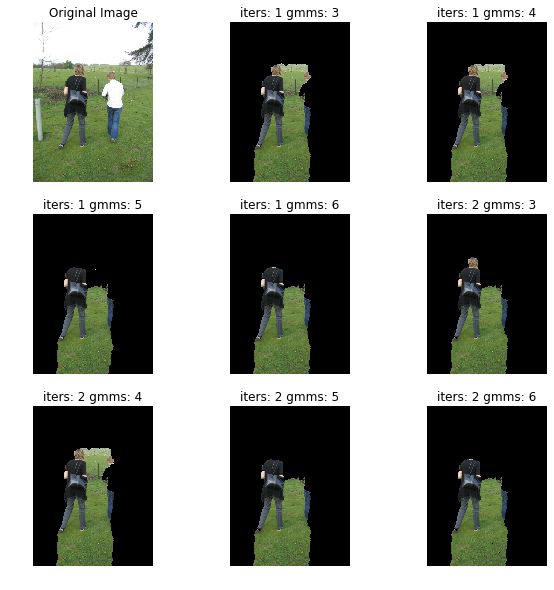

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


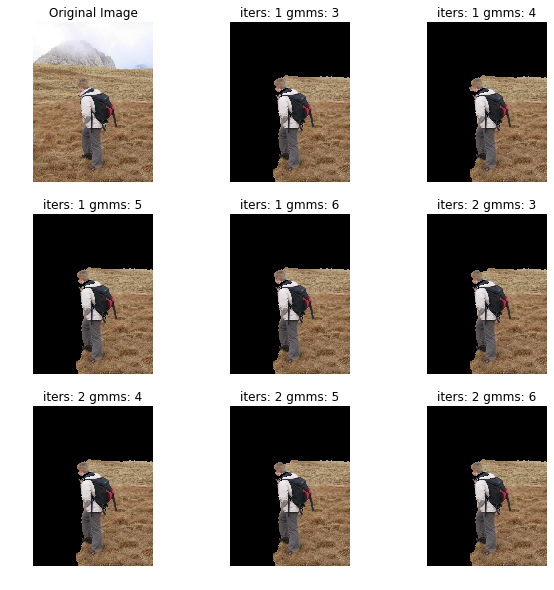

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


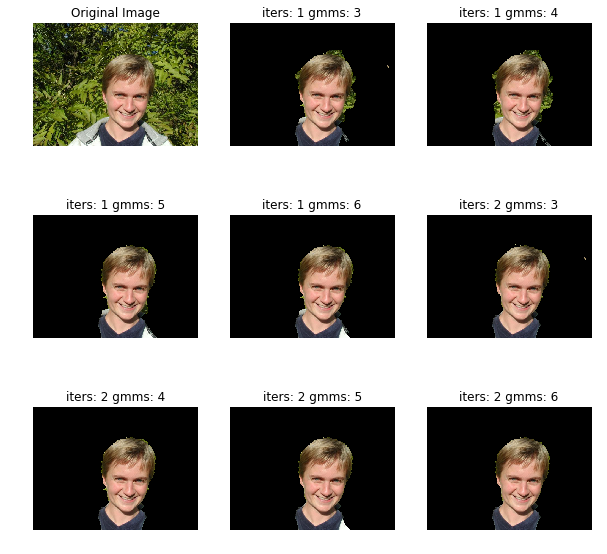

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


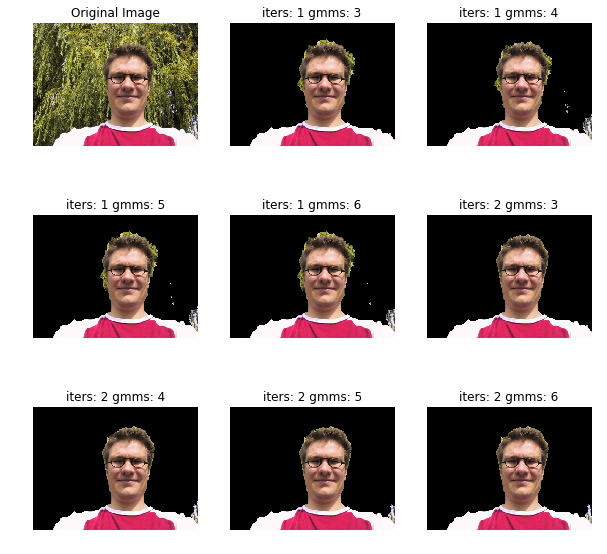

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


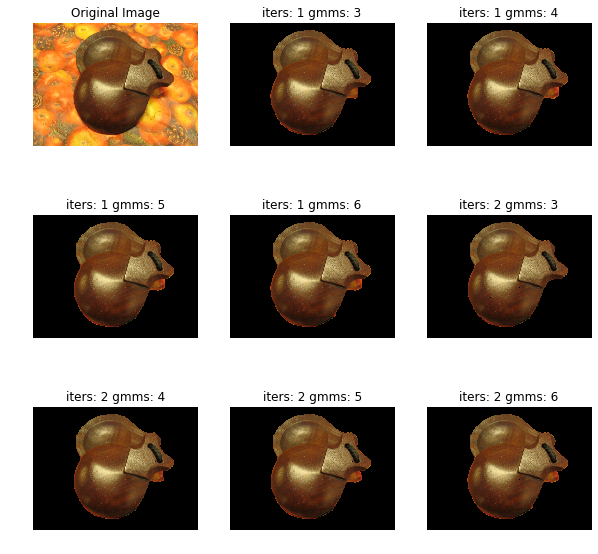

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


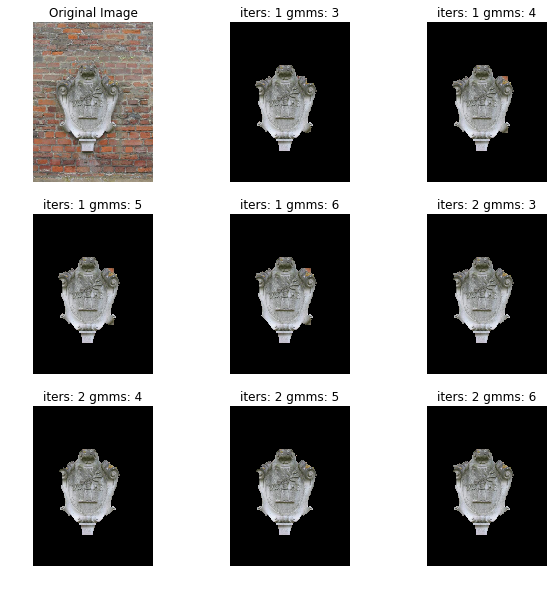

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


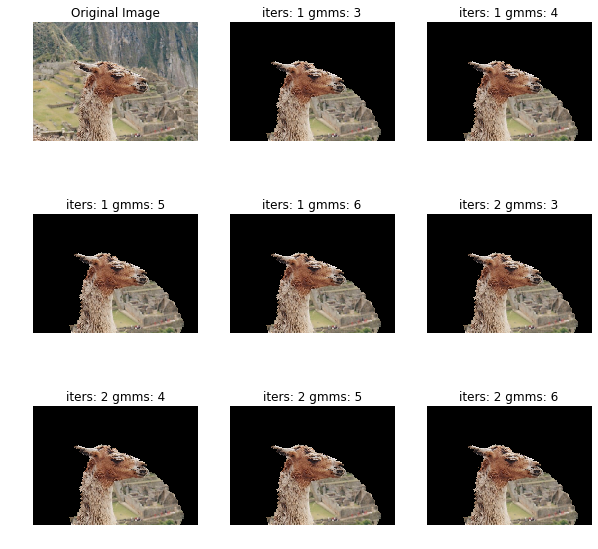

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


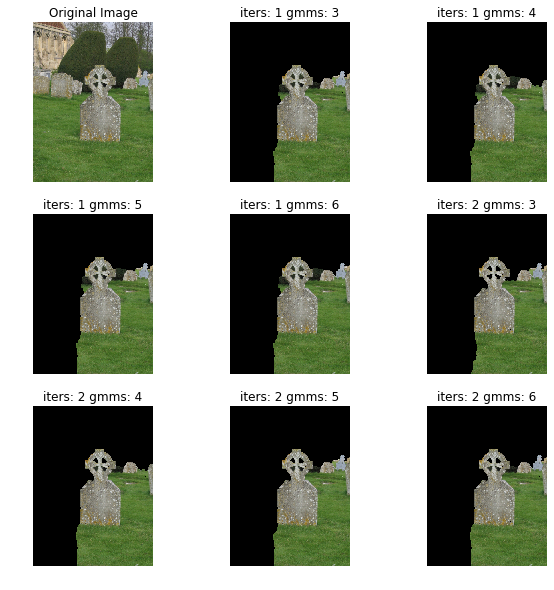

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


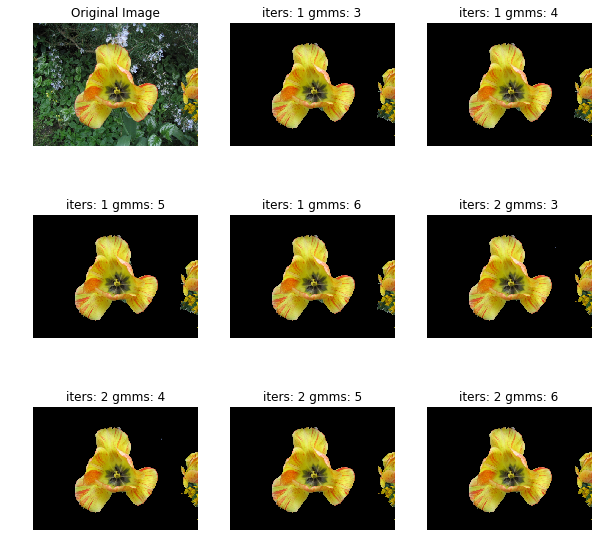

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


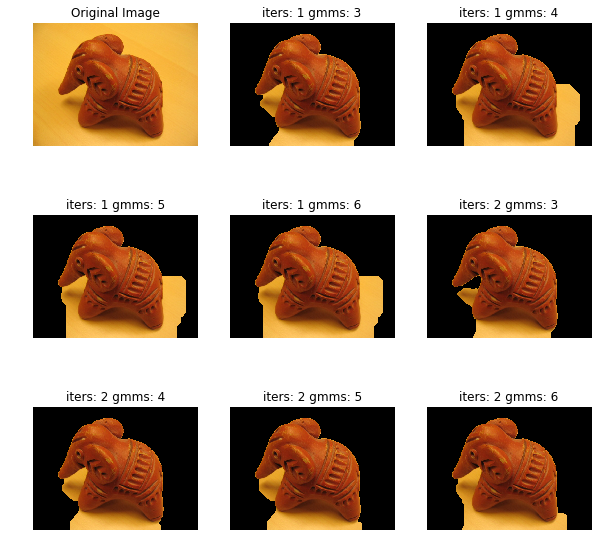

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


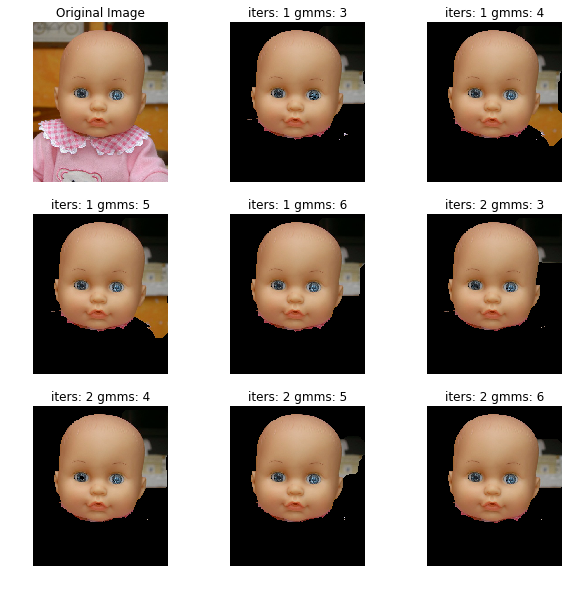

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


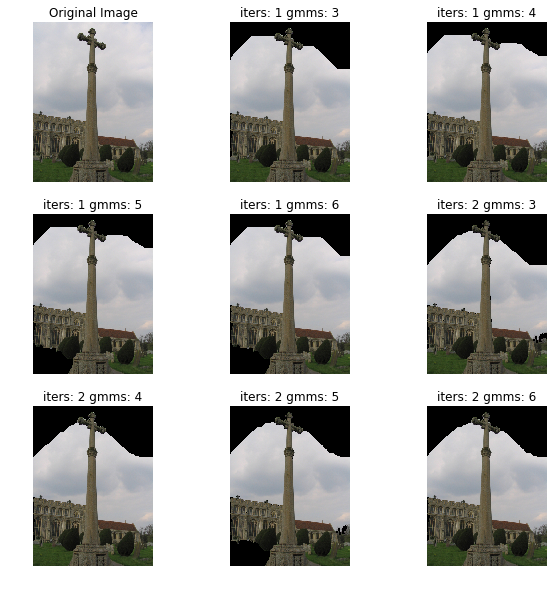

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


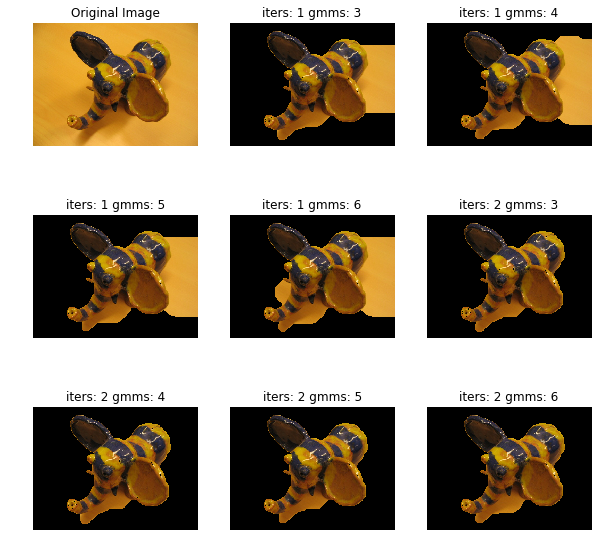

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


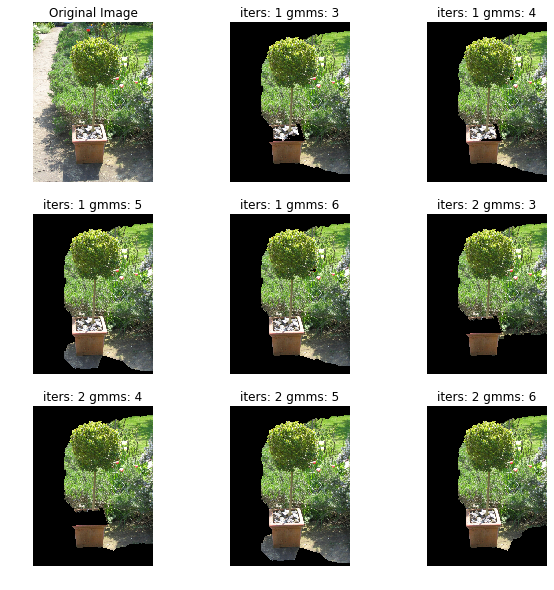

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


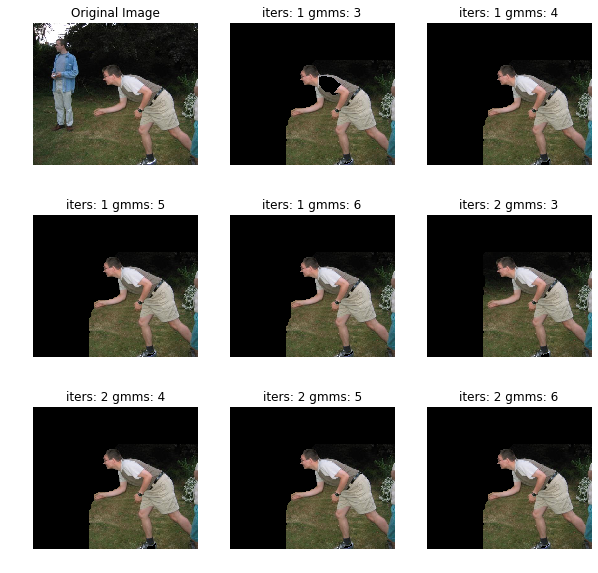

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


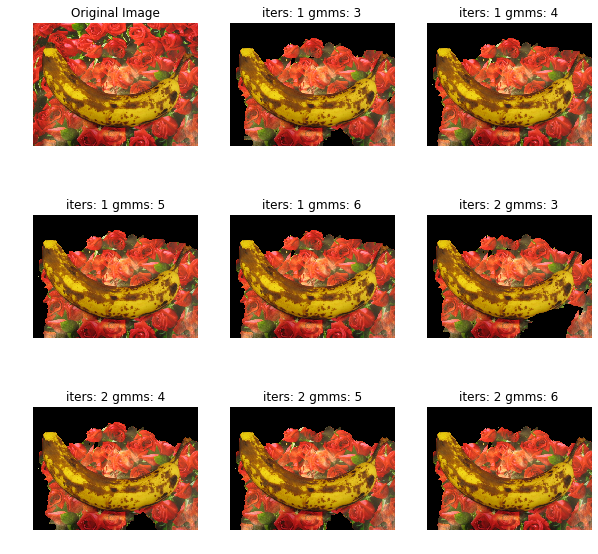

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


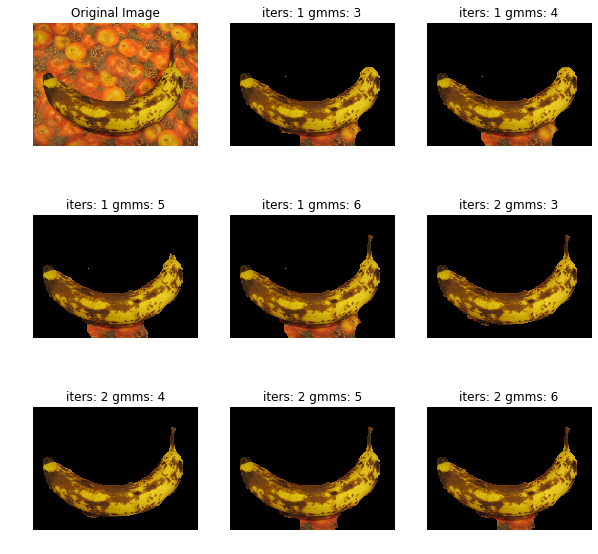

iters:  1 num_comps:  3
iters:  1 num_comps:  4
iters:  1 num_comps:  5
iters:  1 num_comps:  6
iters:  2 num_comps:  3
iters:  2 num_comps:  4
iters:  2 num_comps:  5
iters:  2 num_comps:  6


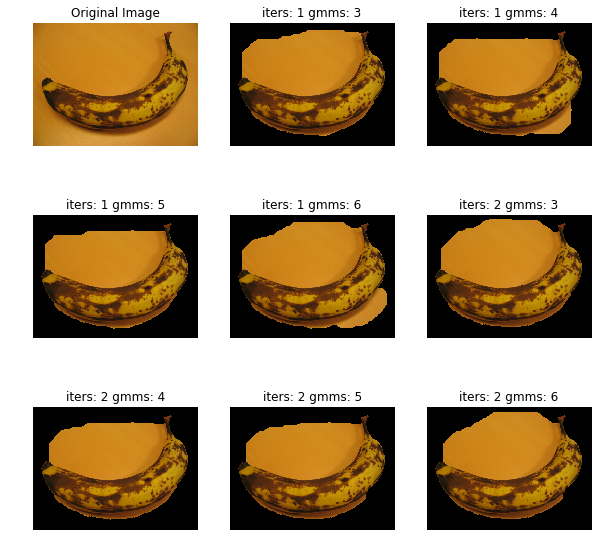

In [26]:
import time
mypath = 'images/'
onlyfiles = [f for f in sorted(listdir(mypath)) if isfile(join(mypath, f))]
onlyfiles.reverse()

for idx, file in enumerate(onlyfiles):
    cnt+=1

    t=time.time()
    img = cv2.imread('images/' + file)
    with open('bboxes/' + file[:-4] + '.txt') as f:
        for line in f:
            line = line.split()
            bbox = line
            bbox = [ int(x) for x in bbox ]
        rect = bbox

    masks={}
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    idx=2
    for i in range(1, 3):
        for j in range(3, 7):
            
    
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            masks["mask_{}_{}".format(i, j)] = grabcut(img, mask, rect, num_iters = i, gmm_comps = j)
            imgc = img.copy()
            output = cv2.bitwise_and(imgc, imgc, mask=masks["mask_{}_{}".format(i, j)]).astype('uint8')
            print("iters: ", i, "num_comps: ", j)
            plt.subplot(3, 3, idx)
            idx+=1
            plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
            plt.title('iters: ' + str(i) + ' gmms: '+ str(j))
            plt.axis('off')
    plt.show()
    

In [27]:
def dynamic_plotting(imglist, rows, cols, title=None):
    plt.figure(figsize=(12, 12))
    idx=1
    if title is None:
        title = [i for i in range(0, rows*cols)]
    for i in range(1, rows+1):
        for j in range(1, cols+1):
            img = cv2.imread(imglist[idx-1])
            plt.subplot(rows, cols, idx)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(title[idx-1])
            idx+=1
            plt.axis('off')
    plt.show()

### Effect of Itereations

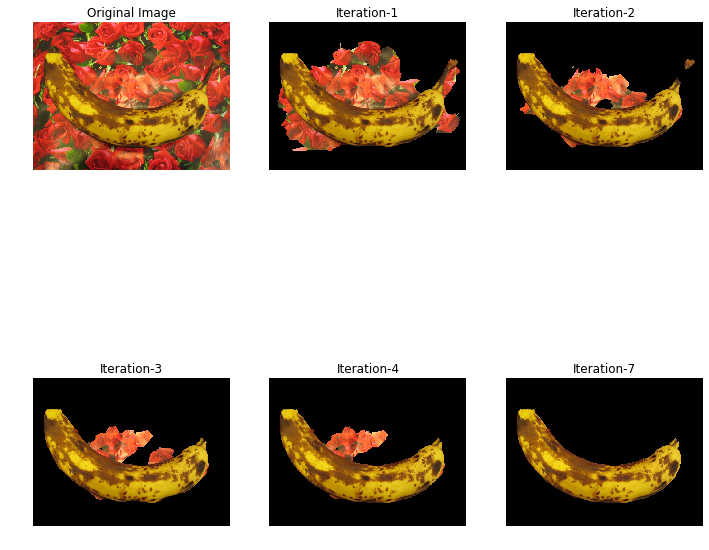

In [28]:
img_list = ["./report/inputs/banana3.jpg", "./report/extra/banana3_1.jpg", "./report/extra/banana3_2.jpg",
           "./report/extra/banana3_3.jpg", "./report/extra/banana3_4.jpg",
           "./report/extra/banana3_7.jpg"]
titles = ["Original Image", "Iteration-1", "Iteration-2", "Iteration-3"
         , "Iteration-4", "Iteration-7"]
dynamic_plotting(img_list, 2, 3, title=titles)


### Effect of Color Space

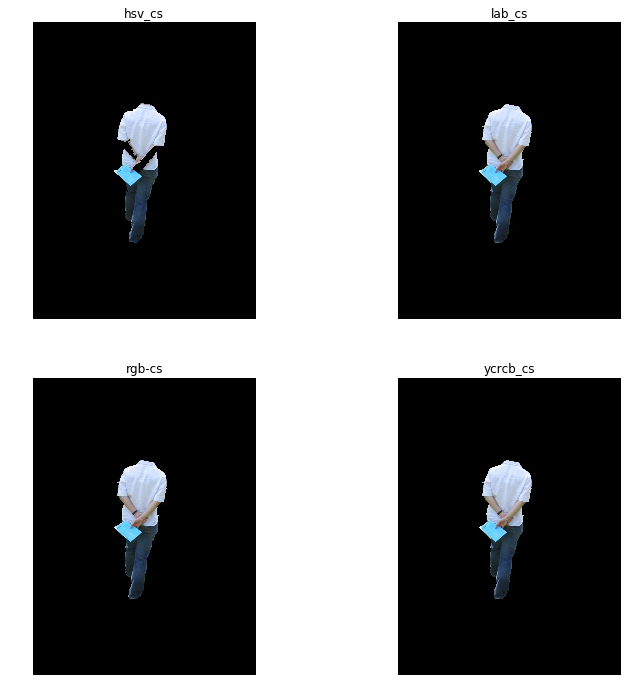

In [30]:
img_list = ["./report/color_space/hsv_cs/person7.jpg", "./report/color_space/lab_cs/person7.jpg",
           "./report/color_space/rgb_cs/person7.jpg", "./report/color_space/ycrcb_cs/person7.jpg"]
titles = ["hsv_cs", "lab_cs", "rgb-cs", "ycrcb_cs"]
dynamic_plotting(img_list, 2, 2, title=titles)

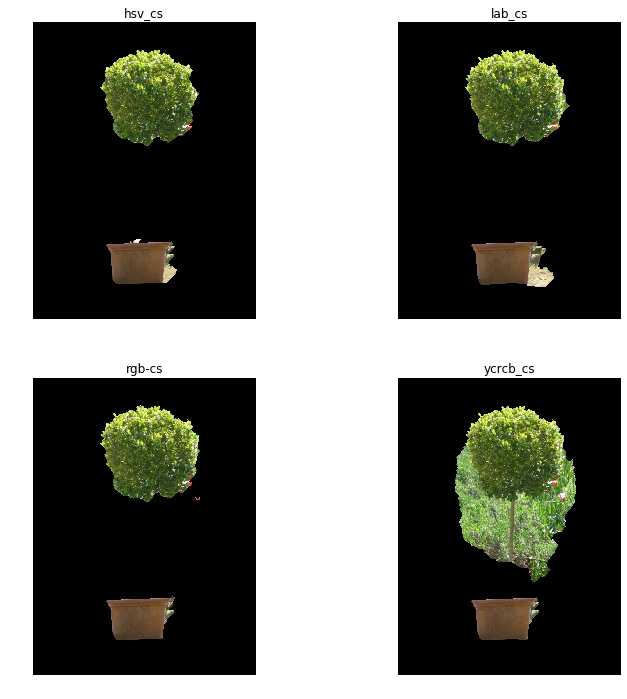

In [31]:
img_list = ["./report/color_space/hsv_cs/bush.jpg", "./report/color_space/lab_cs/bush.jpg",
           "./report/color_space/rgb_cs/bush.jpg", "./report/color_space/ycrcb_cs/bush.jpg"]
titles = ["hsv_cs", "lab_cs", "rgb-cs", "ycrcb_cs"]
dynamic_plotting(img_list, 2, 2, title=titles)

### Effect of Neighbourhood
We can see that 8 - Neighbourhood always produces smoother and better results. 

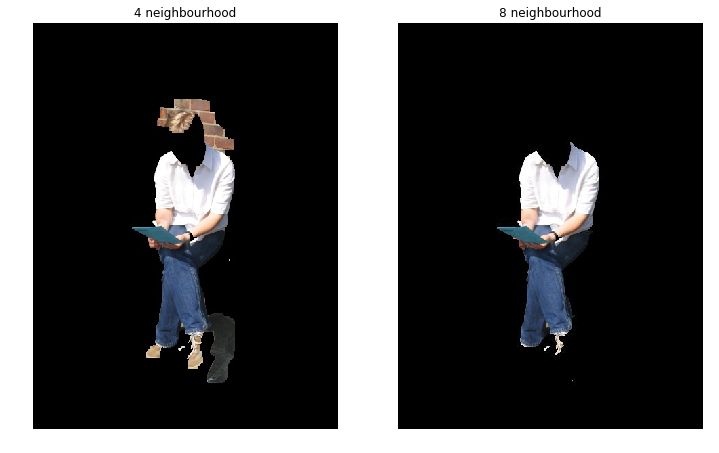

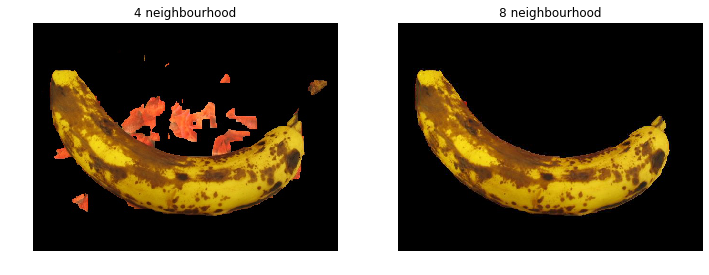

In [34]:
img_list = ["./report/neighbourhood/4_neighbourhood/person6.jpg", "./report/neighbourhood/8_neighbourhood/person6.jpg"]
titles = ["4 neighbourhood", "8 neighbourhood"]
dynamic_plotting(img_list, 1, 2, title=titles)
img_list = ["./report/neighbourhood/4_neighbourhood/banana3.jpg", "./report/neighbourhood/8_neighbourhood/banana3.jpg"]
titles = ["4 neighbourhood", "8 neighbourhood"]
dynamic_plotting(img_list, 1, 2, title=titles)

### Stereo Correspondence using MRF 
- To calculate MRF, we use loopy belief propagation. 
- Belief propagation is a message-passing algorithm for performing inference on graphical models, such as Bayesian networks and Markov random fields.
- It calculates the marginal distribution for each unobserved node, conditional on any observed nodes. 
- Instead, one initializes all variable messages to 1 and uses the same message definitions above, updating all messages at every iteration (although messages coming from known leaves or tree-structured subgraphs may no longer need updating after sufficient iterations). 

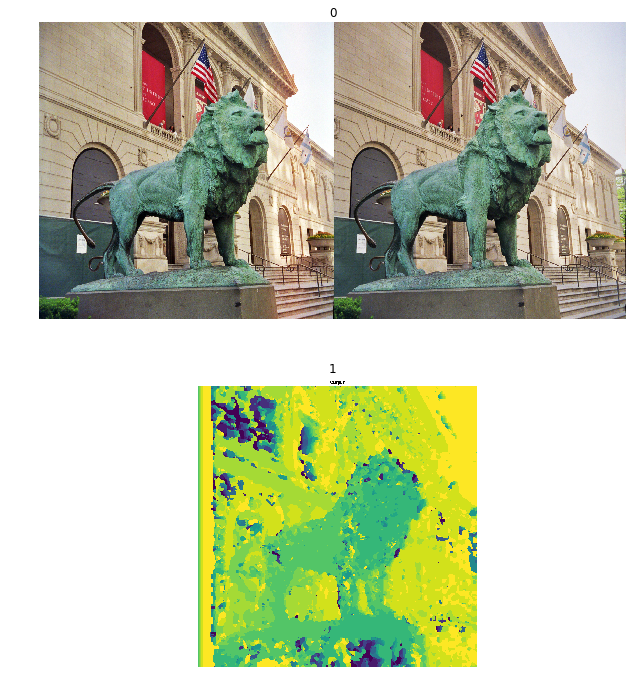

In [36]:
dynamic_plotting(["./report/MRF/Stereo_Pair1.jpg", "./report/MRF/1-out.png"], 2, 1)

We can observe that **MRF** provides good **depth/disparity** maps(as depth is proportional to the disparity in the image). The **green areas are near** the observer(less depth) and the **yellow areas are further**.